# Policy Iteration and Solvers: Homework

## Problem 1: Policy Function Iteration and Value Function Iteration

Compare the speed and accuracy of:
1. Standard value function iteration
2. Value function iteration with policy iteration improvement step.
3. Policy function iteration.

## Problem 2: Newton-Raphson method

1. Write a function for the Newton-Rapshon method
2. Apply it to find the interest rate that clears the asset market. (Same calibration as in class.)
3. Compare the speed and accuracy to the bisection method.

## Problem 3: FOC from Value Function

The FOC for the value function is
\begin{align*}
u'(c(a)) &= \beta (1 + r) V'(a'(a)) \\
a'(a) &= (1+r)a + y - c(a)
\end{align*}

The envelope condition for the value function is
$$
u'(c(a)) = V'(a).
$$


1. Starting with an initial guess $V_0'(a)$, use these conditions to iterate over the derivative of the value function until convergence.
2. Compare speed and accuracy to the three methods in Problem (1).

Bonus: write your code using functions. \
Bonus bonus: write your code using an object.

In [28]:
#packages we need to get started
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import sympy as sp

## Problem 1: Policy Function Iteration and Value Function Iteration

Converged after906iterations
VFI done, 0.27 seconds


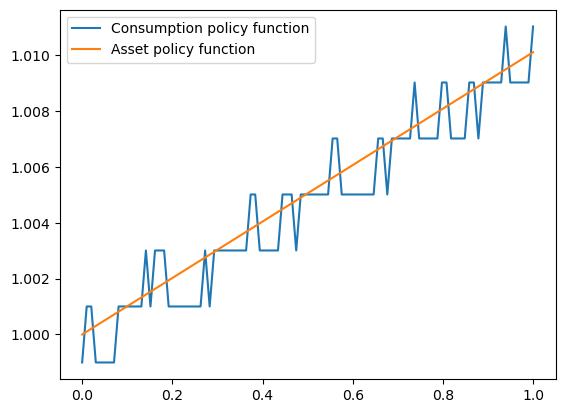

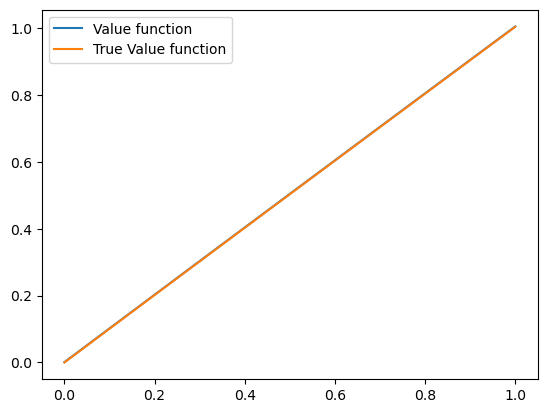

In [11]:
# Standard VFI (Consumption-Savings Problem)

# fix parameters beta, r, and y
beta = 0.99
r = (1/beta) - 1
y = 1
amin = 0
amax = 1
grid_size = 100

# repeat the process until the value function converges
max_iter = 2000
tolerance = 1e-5
dist = 1
iteration = 0

v0 = np.linspace(1, 10, grid_size)
v_new = v0

# define asset grid
a = np.linspace(amin, amax, grid_size)

# initial guess for the value function
v0 = np.linspace(1, 10, grid_size)

# define utility function --- makes it easy to change later
def utility(c):
    return np.log(c)

# we need to solve for the optimal consumption choice. we will do this the complicated way now, and the much easier way later. we will try all possible consumption choices and find the one that maximizes utility. 
c_candidates = y + np.linspace(-0.5, 0.5, 500)

# matrix that holds a' given c_candidates and a
# Note: columns are a, and rows are c_candidates. 
# np.newaxis is used to make sure the dimensions are correct
# Python automatically expands the dimensions of a and c_candidates to make the matrix operation work
a_prime_candidates = (1+r)*a[np.newaxis, :] + y - c_candidates[:, np.newaxis] 

start_time=time.time()   
for iteration in range(max_iter):
    v_old = v_new

    # interpolate value function at a' given c_candidates
    # np.interp interpolates on the columns (last dimension) of a_prime_candidates
    # want to penalize deviations outside the grid, so we use large negative values as a fill value
    f_interp = interp1d(a, v_old, kind='linear', bounds_error=False, fill_value=(-10000, 0))
    v_prime_candidates = f_interp(a_prime_candidates)

    # calculate utility for all possible consumption choices
    utility_values = utility(c_candidates[:, np.newaxis]) + beta * v_prime_candidates

    # find the consumption choice that maximizes utility
    c_index = np.argmax(utility_values, axis=0) 
    c = c_candidates[c_index]
    v_new = np.max(utility_values, axis=0)

    dist = np.max(abs(v_new - v_old))
    
    if dist < tolerance: 
        print('Converged after' + str(iteration) + 'iterations')
        break

print(f"VFI done, {time.time() - start_time:.2f} seconds")
    
# # plot consumption against true consumption function
plt.plot(a, c, label='Consumption policy function')
plt.plot(a, y + r * a, label='Asset policy function')
plt.legend()
plt.show()

# # plot against true value function
plt.plot(a, v_new, label='Value function')
plt.plot(a, utility(y + r * a) / (1-beta), label='True Value function')
plt.legend()
plt.show()
    



Converged after 760 iterations.
VFI done, 0.55 seconds


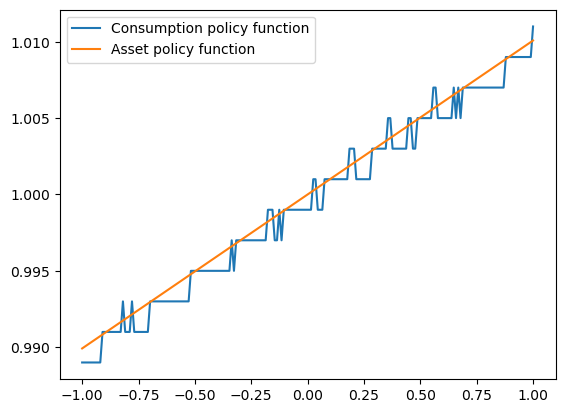

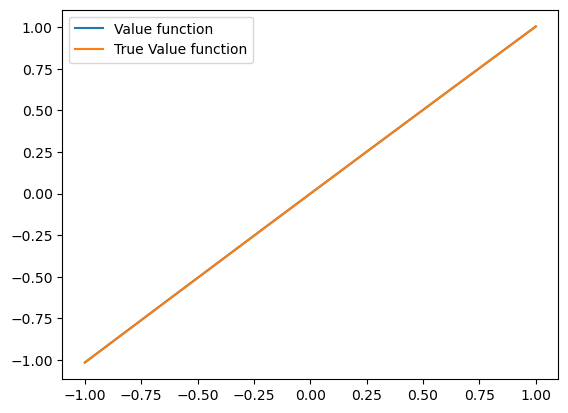

In [12]:
# VFI with policy improvement step 

# same setup as before
max_iter = 2000
policy_iter = 2000
tolerance = 1e-7
iteration = 0
howard_iter = 0

# fix parameters beta, r, and y
beta = 0.99
r = (1/beta) - 1
y = 1
amin = -1
amax = 1
grid_size = 200

# define asset grid
a = np.linspace(amin, amax, grid_size)

# initial guess for the value function
v0 = np.linspace(1, 10, grid_size)

# define utility function --- makes it easy to change later
def utility(c):
    return np.log(c)

v_new = v0

start_time=time.time() 

# Howard iteration in value function consumption problem
while iteration < max_iter:
    v_old = v_new
    # c_candidates and a_prime_candidates can be out of this loop
    c_candidates = y + np.linspace(-0.5, 0.5, 500)
    a_prime_candidates = (1+r)*a[np.newaxis, :] + y - c_candidates[:, np.newaxis]
    f_interp = interp1d(a, v_old, kind='linear', bounds_error=False, fill_value=(-10000, 0))
    v_prime_candidates = f_interp(a_prime_candidates)
    utility_values = utility(c_candidates[:, np.newaxis]) + beta * v_prime_candidates
    c_index = np.argmax(utility_values, axis=0)
    c = c_candidates[c_index]
    v_new = np.max(utility_values, axis=0)

    # add howard iteration here
    # hold consumption fixed and update value function within this loop 
    # this operation is very inexpensive and improves our guess for the value function so that we do less updating optimal consumption policy
    c_policy=c
    u_policy = utility(c_policy)
    a_prime_policy = (1+r)*a + y - c_policy

    while howard_iter < policy_iter:
        f_interp=interp1d(a, v_new, kind='linear', bounds_error=False, fill_value=(-10000, 0))
        v_prime = f_interp(a_prime_policy)
        v_new=u_policy+beta*v_prime
        howard_iter+=1


    if np.max(np.abs(v_new - v_old)) < tolerance:
        print(f'Converged after {iteration} iterations.')
        break
    iteration += 1

print(f"VFI done, {time.time() - start_time:.2f} seconds")

# plot consumption against true consumption function
plt.plot(a, c, label='Consumption policy function')
plt.plot(a, y + r * a, label='Asset policy function')
plt.legend()
plt.show()

# plot against true value function
plt.plot(a, v_new, label='Value function')
plt.plot(a, utility(y + r * a) / (1-beta), label='True Value function')
plt.legend()
plt.show()

Iteration done, 0.05 seconds


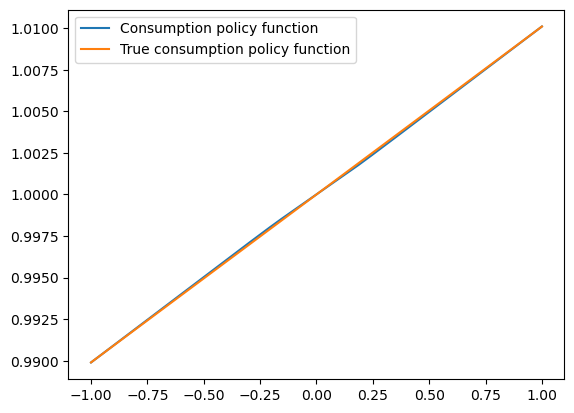

In [13]:
# Policy function iteration i.e. iterate directly on FOC

# define marginal utility function and inverse marginal utility function
def margutility(c):
    return 1 / c 

def invmargutility(uprime):
    return 1 / uprime 

# iterate on the consumption policy function
# start with an intial guess for the consumption policy function
c_old = y + np.zeros(a.shape)
max_iter = 2000
iteration = 0

update = .2

start_time=time.time() 

# iterate until convergence 
while iteration < max_iter: 
        # from the budget constraint, the implied next period assets are
    c_old=update*c_new+(1-update)*c_old
    aprime = (1 + r) * a + y - c_old

    # interpolate c_0 to get cprime (note: different penalties for extrapolation)
    f_interp = interp1d(a, c_old, kind='linear', bounds_error=False, fill_value=(0.0001,(1 + r) * amax + y))
    cprime = f_interp(aprime)

    # the new consumption policy function is
    # update today's consumption using the Euler Equation
    c_new = invmargutility( beta * (1 + r) * margutility(cprime) )

    error=np.max(np.abs(c_new-c_old))
    if np.max(np.abs(c_new-c_old)) < tolerance:
        c_star=c_new
        print(f"Policy function iteration done: {iter} iter, {time.time() - start_time:.2f} seconds")
        break
    
    iteration+=1

print(f"Iteration done, {time.time() - start_time:.2f} seconds")

# # plot consumption against true consumption function
plt.plot(a, c_new, label='Consumption policy function')
plt.plot(a, y + r * a, label='True consumption policy function')
plt.legend()
plt.show()

The policy function iteration is by far the fastest and most accurate of the three. The issue with this method is that convergence is not guaranteed.

## Problem 2: Newton-Raphson Method

In [14]:
# define the function we will use and its derivative 
def f(x):
    return 3*x - 1

def f_prime(x):
    return 3

In [31]:
# Newton-Raphson root finding algorithm

def newton(f,f_prime,x_0): 
    start_time=time.time()
    max_iter = 2000 
    tolerance = 1e-7
    iteration = 0
    
    x=x_0
    while iteration < max_iter: 
        delta=-f(x)/f_prime(x)
        x+=delta

        # check convergence of x
        if np.abs(delta) < tolerance:
            break
            
        iteration+=1
    
    print(f"Newton-Rhapson done, {time.time() - start_time:.2f} seconds")
    return x

root = newton(f, f_prime, 0)

# # print the root
print(root)

Newton-Rhapson done, 0.00 seconds
0.3333333333333333


In [32]:
# bisection algorithm
def bisection(f,a,b):
    start_time=time.time()
    if f(a)*f(b) >0:
        print ("Bisection method fails")
        return None

    while (b-a)>=1e-8:

        c=(a+b)/2
        if abs(f(c))<1e-8:
            break 
        elif f(c)*f(a)<0:
            # if f(c) and f(a) have different signs, the root is in the interval [a,c]
            b=c
        else: 
            # if f(c) and f(b) have different signs, the root is in the interval [c,b]
            a=c
    print(f"Bisection done, {time.time() - start_time:.2f} seconds")
    return c         

# # find the root of the function
root = bisection(f, 0, 1)

# # print the root
print(root)

Bisection done, 0.00 seconds
0.3333333358168602


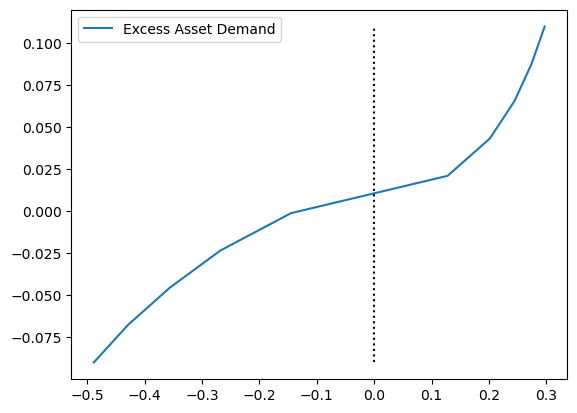

In [33]:
# find and plot excess demand 

asupply = 0
a = np.linspace(amin, amax, grid_size)
index = np.argmin(np.abs(a-asupply))

def excess_demand(r):
# put everything we did before 
# iterate on the consumption policy function
# start with an intial guess for the consumption policy function
    c_new = y+np.zeros(a.shape)
    max_iter = 2000
    iteration = 0
    tolerance=1e-7 
    c_old=c_new

    update = .2

    # iterate until convergence 
    while iteration < max_iter: 
            # from the budget constraint, the implied next period assets are
        c_old=update*c_new+(1-update)*c_old
        aprime = (1 + r) * a + y - c_old

        # interpolate c_0 to get cprime (note: different penalties for extrapolation)
        f_interp = interp1d(a, c_old, kind='linear', bounds_error=False, fill_value=(0.0001,(1 + r) * amax + y))
        cprime = f_interp(aprime)

        # the new consumption policy function is
        # update today's consumption using the Euler Equation
        c_new = invmargutility( beta * (1 + r) * margutility(cprime) )

        error=np.max(np.abs(c_new-c_old))
        if np.max(np.abs(c_new-c_old)) < tolerance:
            c_star=c_new
            print(f"Policy function iteration done: {iter} iter, {time.time() - start_time:.2f} seconds")
            break
        
        iteration+=1

    excess_demand = aprime[index] - asupply
    return excess_demand
    


# # plot consumption against true consumption function
A = 0.5
r_candidates =  (1/beta) - 1 + np.linspace(-0.1, 0.1, 10)
excess_demand_values = np.zeros(10)
for i, r in enumerate(r_candidates):
    excess_demand_values[i] = excess_demand(r)

plt.plot(excess_demand_values, r_candidates, label=f'Excess Asset Demand')
plt.plot(np.zeros_like(r_candidates), r_candidates, 'k:')
plt.legend()
plt.show()

In [38]:
# find root of excess demand using bisection method

rstar = bisection(excess_demand, 0, 2)

print(rstar, (1/beta) - 1)


Bisection done, 4.05 seconds
0.010046593844890594 0.010101010101010166


In [37]:
# find root of excess demand using Newton-Rhapson method

def excess_demand_derivative(r, epsilon=1e-5):
    return (excess_demand(r) - excess_demand(r - epsilon)) / epsilon

# find the root of the function
rstar = newton(excess_demand, excess_demand_derivative, 0)

print(rstar, (1/beta) - 1)

Newton-Rhapson done, 4.00 seconds
0.01004658953249426 0.010101010101010166


Which method is faster depends a lot on which endpoints I start with for bisection method. 

## Problem 3: FOC from Value Function

In [44]:
max_iter = 2000
iteration = 0
tolerance = 1e-8

# start with an initial guess for V'(a)
v_der_new = np.ones(grid_size)

start_time=time.time()
# iterate until convergence 
while iteration < max_iter: 
    v_der=v_der_new
    
    # from the envelope condition, get consumption today
    c=1/v_der

    # from the budget constraint, the implied next period assets are
    aprime = (1 + r) * a + y - c

    # interpolate  to get cprime (note: different penalties for extrapolation)
    f_interp = interp1d(a, v_der, kind='linear', bounds_error=False, fill_value=(0.0001,(1 + r) * amax + y))
    v_der_prime = f_interp(aprime)

    # update today's derivative of the value function using the FOC 
    v_der_new=beta*(1+r)*v_der_prime

    if np.max(np.abs(v_der-v_der_new)) < tolerance:
        v_der_star=v_der_new
        print(f"VFI using FOC done: {iter} iter, {time.time() - start_time:.2f} seconds")
        print('Converged after' + str(iteration) + 'iterations')
        break
    
    iteration+=1